In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras as keras

from keras.models import load_model, Model
from keras.layers import Flatten, Dense, Dropout, Activation, Input, LSTM, Reshape, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from keras.layers import LeakyReLU
from keras.utils import to_categorical
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.layers import MultiHeadAttention

In [25]:

def get_lob_model(latent_dim, T):
	lob_state = keras.layers.Input(shape=(T, 40, 1))

	conv_first1 = keras.layers.Conv2D(32, (1, 2), strides=(1, 2))(lob_state)
	conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
	conv_first1 = keras.layers.Conv2D(32, (4, 1), padding='same')(conv_first1)
	conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
	conv_first1 = keras.layers.Conv2D(32, (4, 1), padding='same')(conv_first1)
	conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)

	conv_first1 = keras.layers.Conv2D(32, (1, 5), strides=(1, 5))(conv_first1)
	conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
	conv_first1 = keras.layers.Conv2D(32, (4, 1), padding='same')(conv_first1)
	conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
	conv_first1 = keras.layers.Conv2D(32, (4, 1), padding='same')(conv_first1)
	conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)

	conv_first1 = keras.layers.Conv2D(32, (1, 4))(conv_first1)
	conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
	conv_first1 = keras.layers.Conv2D(32, (4, 1), padding='same')(conv_first1)
	conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
	conv_first1 = keras.layers.Conv2D(32, (4, 1), padding='same')(conv_first1)
	conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)

	# build the inception module
	convsecond_1 = keras.layers.Conv2D(64, (1, 1), padding='same')(conv_first1)
	convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)
	convsecond_1 = keras.layers.Conv2D(64, (3, 1), padding='same')(convsecond_1)
	convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)

	convsecond_2 = keras.layers.Conv2D(64, (1, 1), padding='same')(conv_first1)
	convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)
	convsecond_2 = keras.layers.Conv2D(64, (5, 1), padding='same')(convsecond_2)
	convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)

	convsecond_3 = keras.layers.MaxPooling2D((3, 1), strides=(1, 1), padding='same')(conv_first1)
	convsecond_3 = keras.layers.Conv2D(64, (1, 1), padding='same')(convsecond_3)
	convsecond_3 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_3)

	convsecond_output = keras.layers.concatenate([convsecond_1, convsecond_2, convsecond_3], axis=3)
	conv_reshape = keras.layers.Reshape((int(convsecond_output.shape[1]), int(convsecond_output.shape[3])))(
		convsecond_output)

	attn_input = conv_reshape
	attn_input_last = attn_input[:, -1:, :]

	multi_head_attn_layer_1 = MultiHeadAttention(num_heads=10, key_dim=16, output_shape=64)

	attn_output, weight = multi_head_attn_layer_1(attn_input_last, attn_input, return_attention_scores=True)

	attn_output = keras.layers.Flatten()(attn_output)

	# add Batch Normalization
	# attn_output = keras.layers.BatchNormalization()(attn_output)

	# add Layer Normalization
	# attn_output = keras.layers.LayerNormalization()(attn_output)

	return keras.models.Model(lob_state, attn_output)

def getLabel(mid_price, horizon, threshold=1e-5):
    price_past = mid_price.rolling(window=horizon).mean()

    price_future = mid_price.copy()
    price_future[:-horizon] = price_past[horizon:]
    price_future[-horizon:] = np.nan

    pct_change = (price_future - price_past)/price_past
    pct_change[pct_change>=threshold] = 1
    pct_change[(pct_change<threshold) & (-threshold<pct_change)] = 2
    pct_change[pct_change<=-threshold] = 3
    return pct_change

def process_data(data):
    #data = data[(data.time > '10:00:00')&(data.time < '14:30:00')]
    data = data.dropna()
    data.y = getLabel(data.midprice, 10)

    for i in range(10):
        data[f'ask_price_{i+1}'] = data[f'ask_price_{i+1}']/data['midprice'] - 1
        data[f'bid_price_{i+1}'] = data[f'bid_price_{i+1}']/data['midprice'] - 1
        data[f'ask_quantity_{i+1}'] = data[f'ask_quantity_{i+1}']/data[f'ask_quantity_{i+1}'].max()
        data[f'bid_quantity_{i+1}'] = data[f'bid_quantity_{i+1}']/data[f'bid_quantity_{i+1}'].max()
    data['timestamp'] = pd.to_datetime(data['timestamp'])

    return data.set_index(['timestamp'])

def data_classification(X, Y, T):
	[N, D] = X.shape
	df = np.array(X)
	dY = np.array(Y)
	dataY = to_categorical(dY[T-1:N], 3)
	dataX = np.zeros((N-T+1, T, D))
	for i in range(T, N+1):
		dataX[i-T] = df[i-T:i, :]
	return dataX.reshape(dataX.shape+(1,)), dataY

def prepare_data(file_path):
	df = pd.read_csv(file_path)
	df['midprice'] = 0.5 * (df['ask_price_1'] + df['bid_price_1'])
	df = df.dropna()

	df['y'] = getLabel(df.midprice, 10)
	df['y'] = df['y'] - 1

	for i in range(10):
		df[f'ask_price_{i+1}'] = df[f'ask_price_{i+1}'] / df['midprice'] - 1
		df[f'bid_price_{i+1}'] = df[f'bid_price_{i+1}'] / df['midprice'] - 1
		df[f'ask_quantity_{i + 1}'] = df[f'ask_quantity_{i + 1}'] / df[f'ask_quantity_{i + 1}'].max()
		df[f'bid_quantity_{i + 1}'] = df[f'bid_quantity_{i + 1}'] / df[f'bid_quantity_{i + 1}'].max()
	df.set_index('timestamp', inplace=True)

	all_columns = []
	for index in range(1,11):
		all_columns.append(f"ask_quantity_{index}")
		all_columns.append(f"ask_price_{index}")
		all_columns.append(f"bid_quantity_{index}")
		all_columns.append(f"bid_price_{index}")
	all_columns.append('y')
	df = df[all_columns]
	df = df.dropna()
	return np.array(df)


In [26]:

df_train = prepare_data(r'data/600519/20230320/order_book.csv')
df_val = prepare_data(r'data/600519/20230321/order_book.csv')
df_test = prepare_data(r'data/600519/20230322/order_book.csv')

In [27]:

T=50
trainX, trainY = data_classification(df_train[:-10,:-1], df_train[:-10, -1:], T)
valX, valY = data_classification(df_val[:-10,:-1], df_val[:-10, -1:], T)
testX, testY = data_classification(df_test[:-10,:-1], df_test[:-10, -1:], T)

print(trainX.shape, trainY.shape)
print(valX.shape, valY.shape)
print(testX.shape, testY.shape)

(48595, 50, 40, 1) (48595, 3)
(75751, 50, 40, 1) (75751, 3)
(43013, 50, 40, 1) (43013, 3)


In [28]:

from tensorflow import keras
from tensorflow.compat.v1.keras import backend as K
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.compat.v1.Session(config=config))

checkpoint_filepath = 'model_tensorflow2/weights_china'

lob_model = get_lob_model(64, T)
lob_model.summary()

def get_pretrain_model(model, T):
    lob_state = keras.layers.Input(shape=(T, 40, 1))
    embedding = model(lob_state)
    output = keras.layers.Dense(3, activation='softmax')(embedding)

    return keras.models.Model(lob_state, output)

china_model = get_pretrain_model(lob_model, T)
china_model.summary()

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
	filepath = checkpoint_filepath,
	save_weights_only = True,
	monitor = 'val_loss',
	mode = 'auto',
	save_best_only = True
)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 40, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 50, 20, 32)   96          ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 50, 20, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 50, 20, 32)   4128        ['leaky_re_lu[0][0]']            
                                                                                              

 model (Functional)          (None, 64)                176320    
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 176,515
Trainable params: 176,515
Non-trainable params: 0
_________________________________________________________________


In [30]:
adam = keras.optimizers.Adam(learning_rate=0.0001)
china_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

china_model.fit(trainX, trainY, validation_data=(valX, valY), epochs=30, batch_size=64, verbose=2, callbacks=[model_checkpoint_callback])



Epoch 1/30
760/760 - 22s - loss: 0.9866 - accuracy: 0.4862 - val_loss: 1.1340 - val_accuracy: 0.3842 - 22s/epoch - 28ms/step
Epoch 2/30
760/760 - 19s - loss: 0.9778 - accuracy: 0.4893 - val_loss: 1.1422 - val_accuracy: 0.4020 - 19s/epoch - 25ms/step
Epoch 3/30
760/760 - 21s - loss: 0.9647 - accuracy: 0.4999 - val_loss: 1.2176 - val_accuracy: 0.3633 - 21s/epoch - 28ms/step
Epoch 4/30
760/760 - 19s - loss: 0.9555 - accuracy: 0.5088 - val_loss: 1.2108 - val_accuracy: 0.3859 - 19s/epoch - 25ms/step
Epoch 5/30
760/760 - 19s - loss: 0.9448 - accuracy: 0.5164 - val_loss: 1.2804 - val_accuracy: 0.3948 - 19s/epoch - 25ms/step
Epoch 6/30
760/760 - 19s - loss: 0.9349 - accuracy: 0.5226 - val_loss: 1.2471 - val_accuracy: 0.3821 - 19s/epoch - 25ms/step
Epoch 7/30
760/760 - 19s - loss: 0.9248 - accuracy: 0.5283 - val_loss: 1.3316 - val_accuracy: 0.3662 - 19s/epoch - 25ms/step
Epoch 8/30
760/760 - 19s - loss: 0.9144 - accuracy: 0.5376 - val_loss: 1.2752 - val_accuracy: 0.3764 - 19s/epoch - 25ms/step


In [34]:
import os
os.getcwd()

'/userhome/cs/dengcfei/MarketMakingViaReinforcementLearning'

In [35]:
china_model.save_weights(r"model_tensorflow2/china_model.weights.h5")

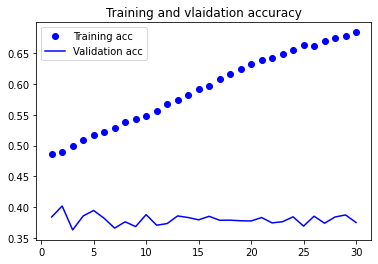

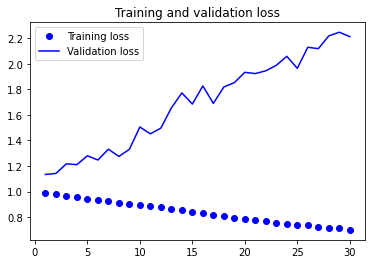

ValueError: Classification metrics can't handle a mix of unknown and multiclass targets

In [36]:

acc = china_model.history.history['accuracy']
val_acc = china_model.history.history['val_accuracy']
loss = china_model.history.history['loss']
val_loss = china_model.history.history['val_loss']
epochs = range(1, len(acc)+1 )
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title("Training and vlaidation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label="Training loss")
plt.plot(epochs, val_loss, 'b', label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

pred = china_model.predict(testX)
print('test accuracy: ', accuracy_score(np.argmax(testX, axis=1), np.argmax(pred, axis=1)))
print(classification_report(np.argmax(testY, axis=1), np.argmax(pred, axis=1), digits=4))